In [1]:
import path_setup
import scipy.io as spio
import mat73
import scipy.io.matlab as spiomat
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import matplotlib
from sklearn.model_selection import train_test_split
from blind_localization.data.datasets import *
from blind_localization.models.contrastive import *
from blind_localization.models.contrastive_pipeline import *
from blind_localization.models.decoder import *
from blind_localization.visualize import *
from tqdm import tqdm
import wandb
import pickle
from script.utils import save_if_better
from sklearn.linear_model import LogisticRegression

/home/th3129/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

parent_dir = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(parent_dir)

### Helper Function

In [4]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    try:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        return _check_keys(data)
    except:
        return mat73.loadmat(filename)

In [5]:
class DotDict(dict):
    # def __getattr__(self, name):
    #     return self[name]
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    def __init__(self, dct):
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DotDict(value)
            self[key] = value
    
    def __repr__(self) -> str:
        return str(list(self.keys()))
    
    def __getstate__(self):
        # Return what you want to pickle
        return self.__dict__

    def __setstate__(self, state):
        # Restore state from the unpickled state
        self.__dict__.update(state)
    

def loadmat_full(filename,structname=None):
    if structname is None:
        mat = loadmat(filename)
    else:
        mat = loadmat(filename)[structname]
    mat = DotDict(mat)
    return mat

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        # if isinstance(dict[key], spiomat.mio5_params.mat_struct):
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
        
        elif isinstance(dict[key], np.ndarray):
            
            dict_key_res = np.zeros_like(dict[key])
            # with np.nditer([dict[key],dict_key_res],op_flags=[['readonly'], ['readwrite']]) as it:
            for ind,x in np.ndenumerate(dict_key_res): 
                orig_val = dict[key][ind]
                
                if isinstance(orig_val,scipy.io.matlab.mat_struct):
                    dict_key_res[ind] = _todict(orig_val)
                else:
                    dict_key_res[ind] = orig_val

            dict[key] = dict_key_res
        
    return dict

In [6]:
def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        # if isinstance(elem, spiomat.mio5_params.mat_struct):
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray) and len(elem) >= 1: # used for the multi maze case; then there might be a cell array of struct that is not correctly unwrapped
            # if isinstance(elem[0], spiomat.mio5_params.mat_struct):
            if isinstance(elem, scipy.io.matlab.mat_struct):
                dict[strg] = np.array([_todict(e) for e in elem],dtype=object)
            else:
                dict[strg] = elem
        else:
            dict[strg] = elem
    return dict

### 1. Load Raw Waveform

In [7]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
session_names = ['AD_HF01_1', 'AD_HF02_2', 'AD_HF02_4', 'AD_HF03_1', 'AD_HF03_2', 'NN_syn_01', 'NN_syn_02']
waveforms_all = []
class_labels_selected_all = []  # class_labels of channels with maxWaveform assigned to it
class_labels_all = []
maxWaveformCh_all = []
channel_channel_maps = []

for i, session in enumerate(sessions):
    file_path = f"/scratch/th3129/shared/Neuronexus_dataset/{session}/{session}.spikes.cellinfo.mat"
    mat = loadmat_full(file_path, structname='spikes')

    # find channel_channel_map to fix channel
    source_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", session_names[i])
    public_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", "public")
    
    raw_signal, df, skipped_channels = load_data(source_file["raw_signal_path"], public_file["label_path"], source_file["xml_path"], sheet_name=source_file["sheet_name"],
                                                 sample_rate=20000, T=30)
    channel_region_map, skipped_channels, channel_channel_map = process_labels(df, public_file["mapping_path"], skipped_channels)
    raw_signal = process_signals(raw_signal, channel_channel_map)

    # load raw signal and raw waveform
    raw_signal, class_labels, swr_timestamp = load_signal_labels(session_names[i])
    
    raw_waveforms = np.vstack(mat['rawWaveform'])
    maxWaveformCh = np.array([channel_channel_map[maxCh] for maxCh in mat['maxWaveformCh']])
    class_label_selected = class_labels[maxWaveformCh]

    waveforms_all.append(raw_waveforms[class_label_selected != 5])
    class_labels_selected_all.append(class_label_selected[class_label_selected != 5])
    maxWaveformCh_all.append(maxWaveformCh[class_label_selected != 5])
    class_labels_all.append(class_labels)
    channel_channel_maps.append(channel_channel_map)

100%|██████████| 1024/1024 [00:02<00:00, 505.11it/s]


In [8]:
color_names = ["red", "orange", "green", "blue", "magenta", "black"]
colors_all = [[color_names[c] for c in class_labels] for class_labels in class_labels_selected_all]

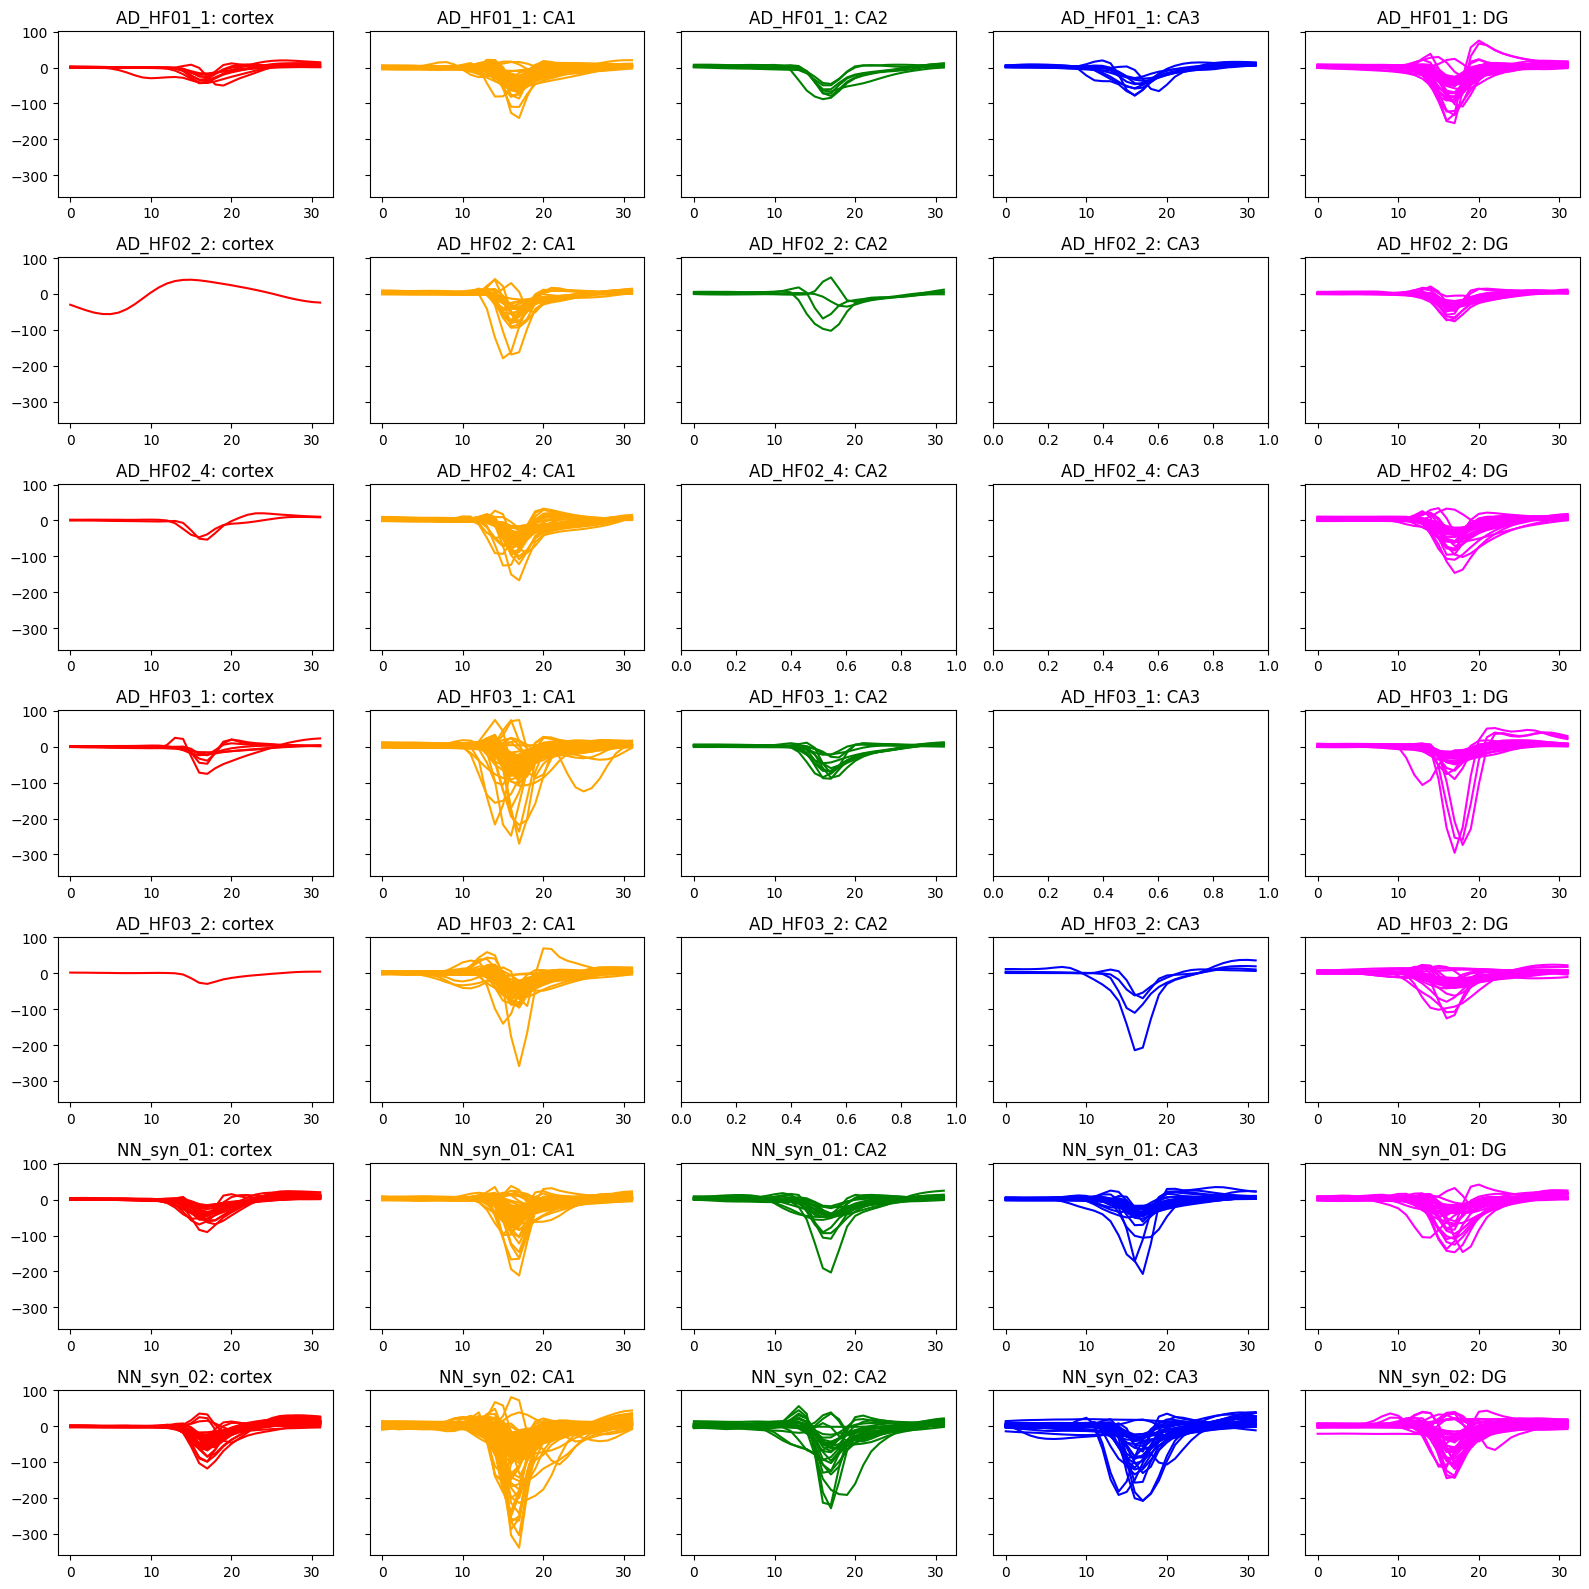

In [9]:
# normalize by the channels in std
fig, axes = plt.subplots(len(sessions), len(color_names)-1, figsize=(16, 16), sharey=True)
brain_regions = ['cortex', 'CA1', 'CA2', 'CA3', 'DG']

for s in range(len(session_names)):
    for color_idx, color in enumerate(color_names[:-1]):
        raw_waveforms = waveforms_all[s]
        colors = colors_all[s]
        
        for i, (wav, wav_color) in enumerate(zip(raw_waveforms, colors)):
            if wav_color == color:
                axes[s][color_idx].plot(wav, c=color)
    
        axes[s][color_idx].set_title(f"{session_names[s]}: {brain_regions[color_idx]}")

plt.tight_layout()
plt.show()

In [10]:
# for each spike time, extract the LFP signal (and spike waveforms) for that trial
# spike_times = mat['times']
# t_min, t_max = 2160, 2340
# selected_timestamp = [s[(s > t_min) & (s < t_max)] for s in spike_times]

In [11]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
channel_waveforms_all = []
goodChannels_all = []

for i, session in enumerate(sessions):
    file_path = f"/scratch/th3129/region_decoding/data/Neuronexus/waveforms/{sessions[i]}_waveforms.mat"
    mat = loadmat_full(file_path, structname='spikesNew')
    waveform_dist = np.array(mat['avgWaveform'])

    file_path = f"/scratch/th3129/shared/Neuronexus_dataset/{session}/{session}.session.mat"
    mat = loadmat_full(file_path, structname='session')
    badChannels = mat['channelTags']['Bad']['channels']
    badChannels = badChannels - 1
    channel_channel_map = channel_channel_maps[i]
    badChannels = np.array([channel_channel_map[int(ch)] for ch in badChannels])
        
    goodChannels = np.setdiff1d(np.arange(1024), badChannels)
    
    channel_waveforms_all.append(waveform_dist)
    goodChannels_all.append(goodChannels)

In [12]:
goodChannels

array([   0,    1,    2, ..., 1021, 1022, 1023])

In [13]:
def visualize_channel_waveform(all_waveforms, all_channels, maxWaveformChannels=None, rows=128, cols=8, scale=100, top_n=5, n_neurons=5, percentile=80, channel_samples=4):
    fig, ax = plt.subplots()

    for n in range(n_neurons):
        waveforms = all_waveforms[n]
        channels = all_channels[::channel_samples]
        
        xs = channels // rows * scale
        ys = np.mod(channels, rows) 
    
        amplitudes = [np.max(np.abs(waveform)) for waveform in waveforms]
        top_n_amplitudes = sorted(amplitudes, reverse=True)[:top_n]
        scaling_factor = np.mean(top_n_amplitudes)
        amp_threshold = np.percentile(amplitudes, percentile)
        
        scaled_waveforms = [waveform / scaling_factor for waveform in waveforms]
        norm_amplitudes = (amplitudes - np.min(amplitudes)) / (np.max(amplitudes) - np.min(amplitudes) + 1e-8)
        
        cmap = cm.YlOrBr
        colors = cmap(norm_amplitudes)
        
        ax.scatter(xs, ys, color='gray')
        
        for i, (x, y) in enumerate(zip(xs, ys)):            
            offset_waveform = scaled_waveforms[i] *5 + y
            if amplitudes[i] > amp_threshold:
                ax.plot(np.arange(len(waveforms[i])) + x, offset_waveform, color=colors[i])

    if maxWaveformChannels is not None:
        xs = maxWaveformChannels // rows * scale
        ys = np.mod(maxWaveformChannels, rows)
        ax.scatter(xs, ys, color='blue')
        
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(amplitudes), vmax=np.max(amplitudes)))
    sm.set_array([])  # Required for ScalarMappable to work
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Amplitude')
            
    plt.show()

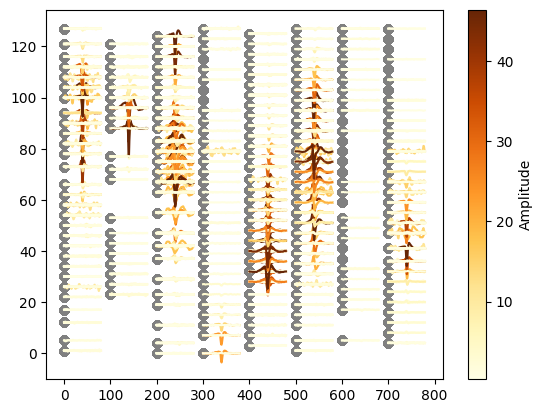

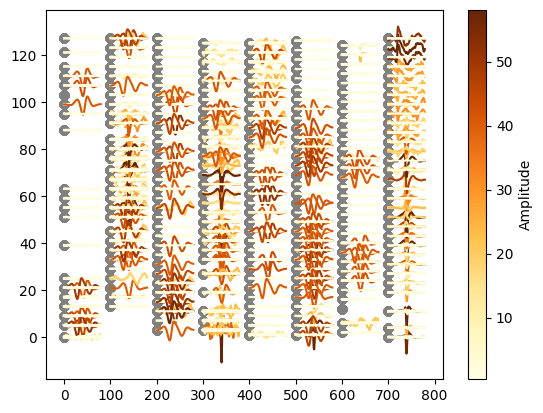

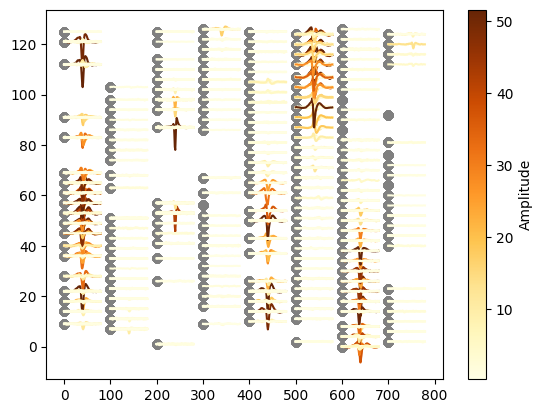

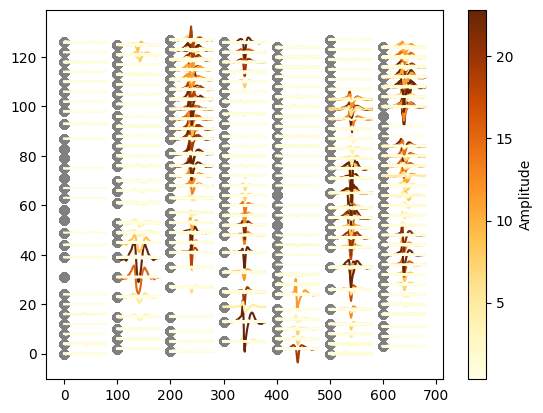

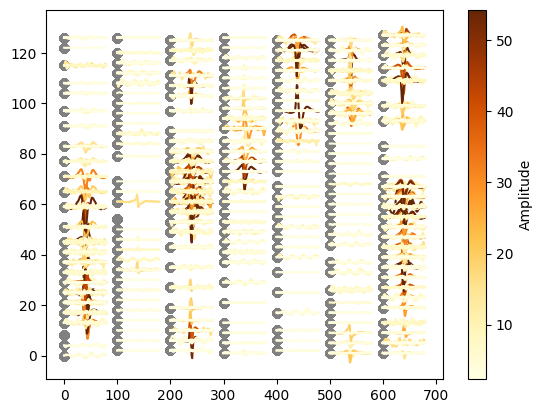

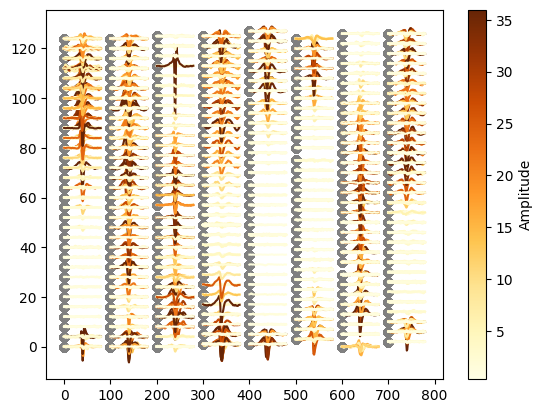

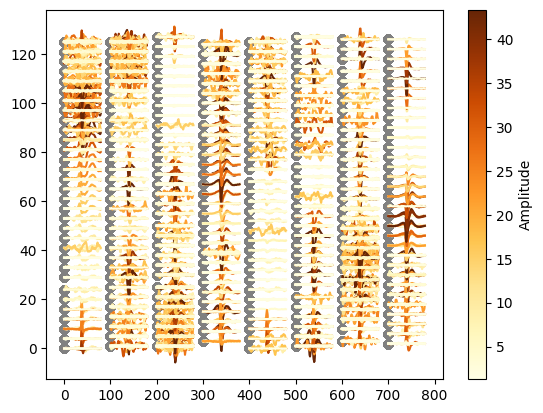

In [14]:
for i in range(len(channel_waveforms_all)):
    visualize_channel_waveform(channel_waveforms_all[i], goodChannels_all[i], n_neurons=len(channel_waveforms_all[i]), percentile=90, channel_samples=4)

### 2. Predict with Waveform Distribution

In [15]:
waveforms_per_channel = channel_waveforms_all[0].transpose(1, 0, 2).reshape(channel_waveforms_all[0].shape[1], -1)
class_labels_good_channels = class_labels_all[0][goodChannels_all[0]]
print("n_neurons, n_channels, n_time: ", waveforms_per_channel.shape)
print("n_labels: ", class_labels_good_channels.shape)

n_neurons, n_channels, n_time:  (917, 14720)
n_labels:  (917,)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

data = waveforms_per_channel[class_labels_good_channels != 5]
labels = class_labels_good_channels[class_labels_good_channels != 5]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.9307692307692308


In [27]:
channel_pc_all = []
channel_waveforms_selected_all = []
channel_labels_all = []

for i in range(len(channel_waveforms_all)):
    waveforms_per_channel = channel_waveforms_all[i].transpose(1, 2, 0).reshape(channel_waveforms_all[i].shape[1], -1)
    class_labels_good_channels = class_labels_all[i][goodChannels_all[i]]
    
    data = waveforms_per_channel[class_labels_good_channels != 5]
    labels = class_labels_good_channels[class_labels_good_channels != 5]

    pca = PCA(n_components=10)
    channel_pc = pca.fit_transform(data)

    channel_waveforms_selected_all.append(data)
    channel_pc_all.append(channel_pc)
    channel_labels_all.append(labels)

In [28]:
waveform_results_within = []

for i in range(len(channel_waveforms_all)):
    X_train, X_test, y_train, y_test = train_test_split(channel_waveforms_selected_all[i], channel_labels_all[i], test_size=0.2, random_state=42)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    waveform_results_within.append(accuracy_score(y_test, y_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.9307692307692308


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.9514563106796117
Test Accuracy: 0.8631578947368421
Test Accuracy: 0.9117647058823529
Test Accuracy: 0.9615384615384616
Test Accuracy: 0.9819819819819819
Test Accuracy: 1.0


In [29]:
index_train, index_test = train_test_split(np.arange(len(session_names)), test_size=0.2, random_state=42)

In [30]:
X_train = np.vstack([channel_pc_all[i] for i in index_train])
X_test = np.vstack([channel_pc_all[i] for i in index_test])

y_train = np.hstack([channel_labels_all[i] for i in index_train])
y_test = np.hstack([channel_labels_all[i] for i in index_test])

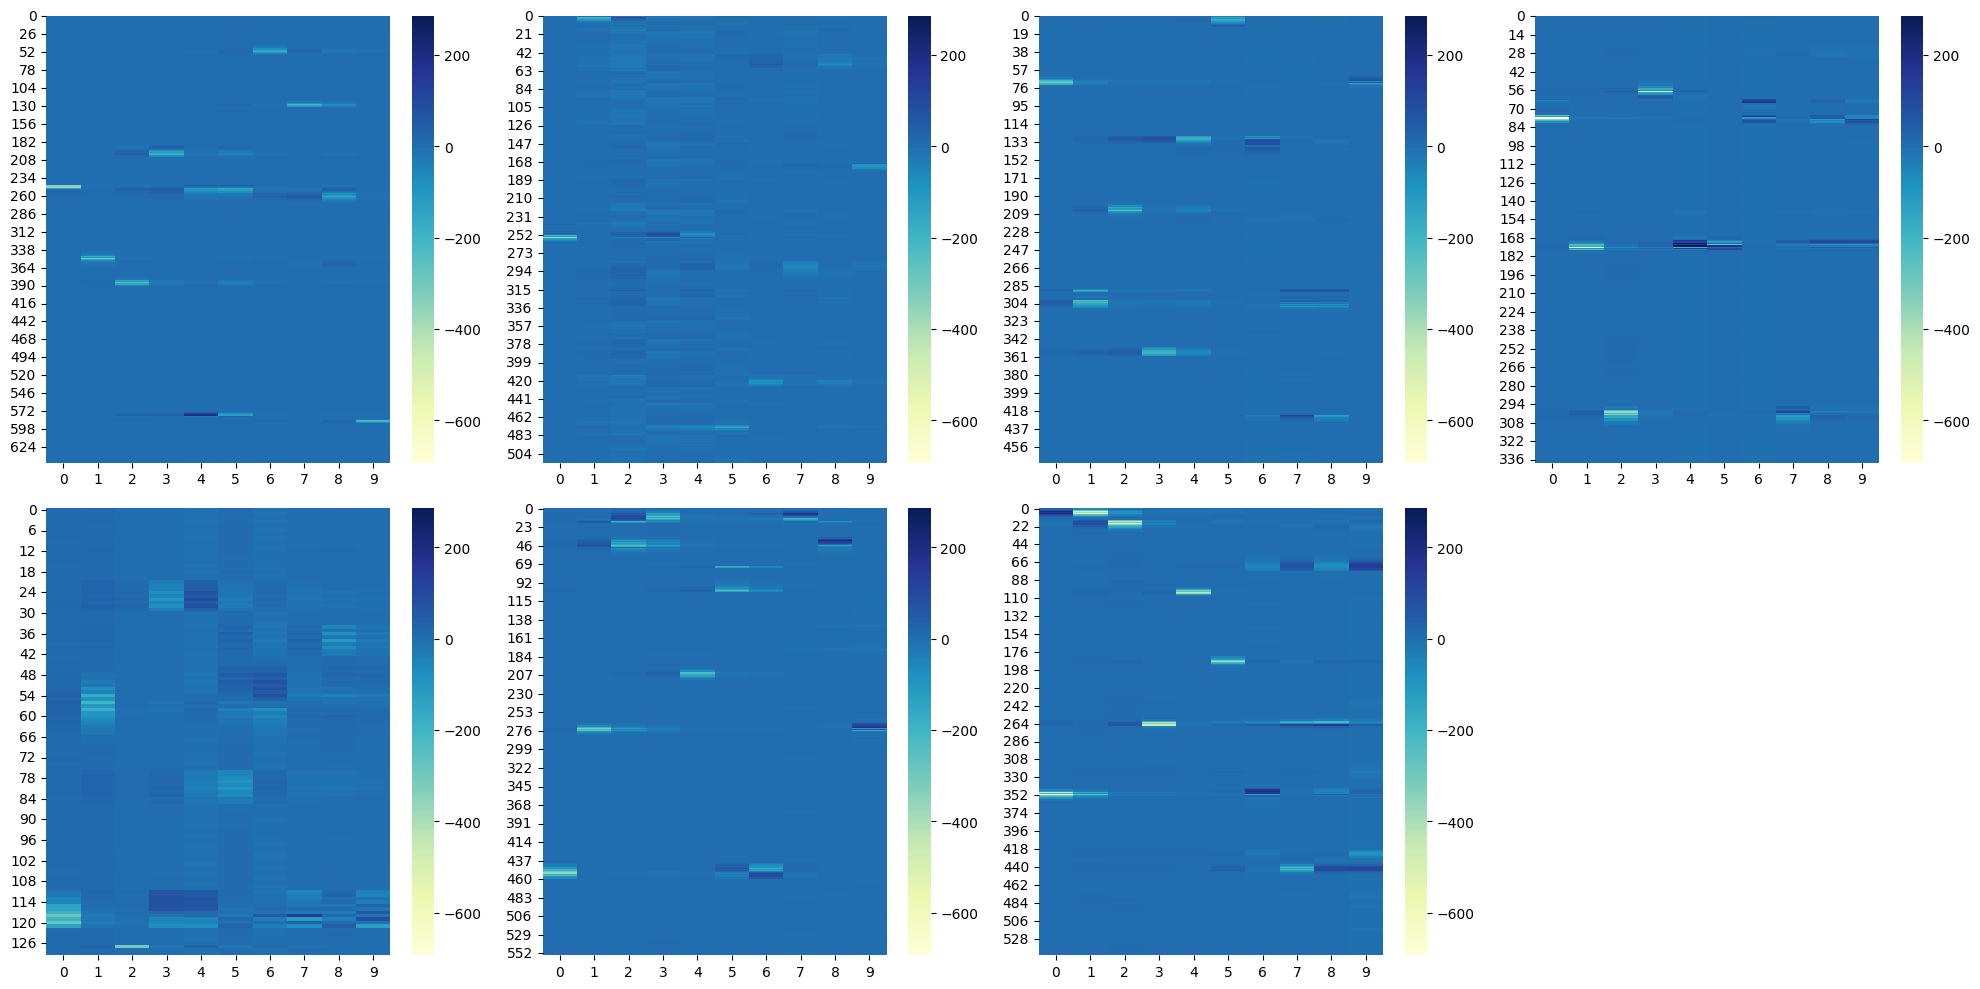

In [35]:
all_values = np.concatenate([matrix.flatten() for matrix in channel_pc_all])
vmin, vmax = all_values.min(), all_values.max()

plt.figure(figsize=(20, 10))
for i in range(len(session_names)):
    plt.subplot(2, 4, i+1)
    sns.heatmap(channel_pc_all[i], vmin=vmin, vmax=vmax, fmt="d", cmap="YlGnBu")
plt.tight_layout()

In [36]:
clf = LogisticRegression(C=1e-5)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.4095796676441838
Test Accuracy: 0.48881239242685026


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


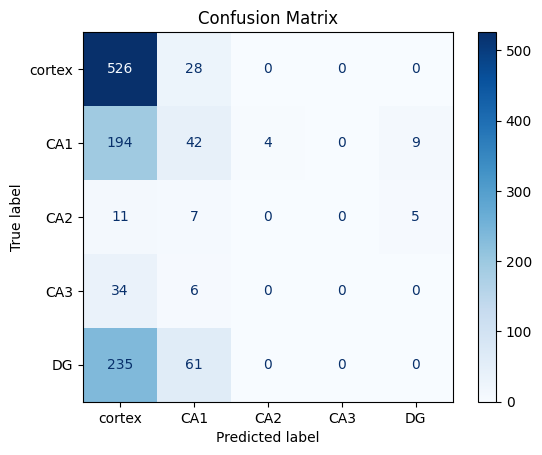

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=brain_regions)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

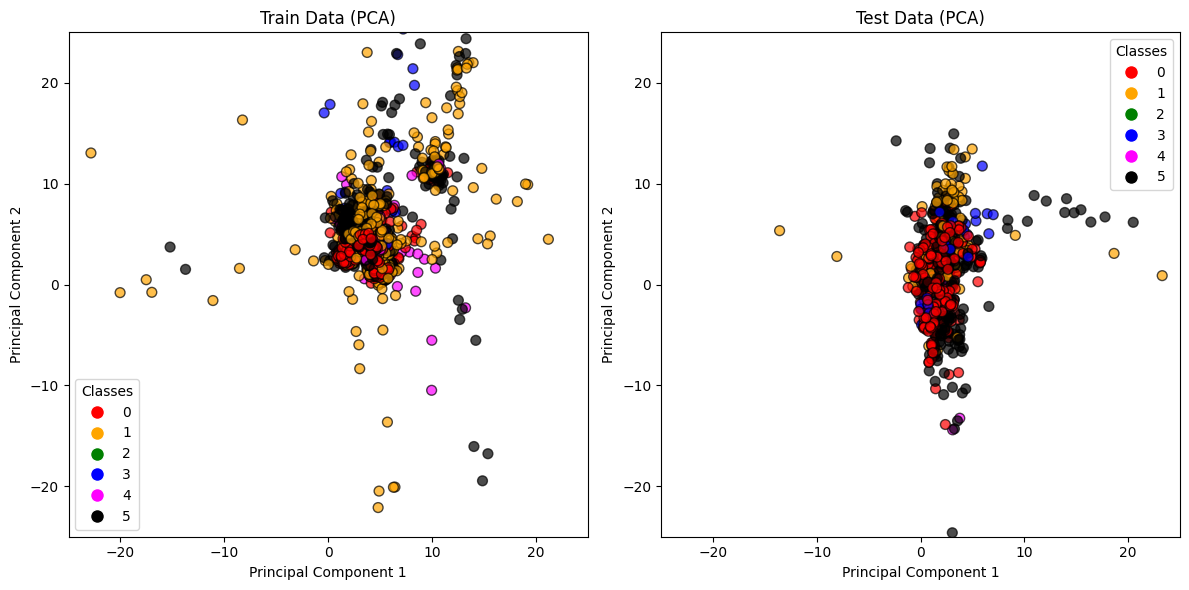

In [22]:
from matplotlib.colors import ListedColormap

color_names = ["red", "orange", "green", "blue", "magenta", "black"]
cmap = ListedColormap(color_names)

train_colors = [color_names[y] for y in y_train]
test_colors = [color_names[y] for y in y_test]

pca = PCA(n_components=2)
pca_train_result = pca.fit_transform(X_train)
pca_test_result = pca.transform(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(pca_train_result[:, 0], pca_train_result[:, 1], c=y_train, cmap=cmap, alpha=0.7, edgecolor='k', s=50)
axes[0].set_title("Train Data (PCA)")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in enumerate(color_names)], 
               title="Classes", loc="best")
axes[0].set_xlim(-25, 25)
axes[0].set_ylim(-25, 25)

axes[1].scatter(pca_test_result[:, 0], pca_test_result[:, 1], c=y_test, cmap=cmap, alpha=0.7, edgecolor='k', s=50)
axes[1].set_title("Test Data (PCA)")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in enumerate(color_names)], 
               title="Classes", loc="best")
axes[1].set_xlim(-25, 25)
axes[1].set_ylim(-25, 25)

plt.tight_layout()
plt.show()

In [43]:
waveform_results_across = []

for index_test in range(len(channel_waveforms_all)):
    index_tests = np.array([index_test])
    index_train = np.setdiff1d(np.arange(len(channel_waveforms_all)) , index_tests) 
    X_train = np.vstack([channel_pc_all[i] for i in index_train])
    X_test = np.vstack([channel_pc_all[i] for i in index_tests])
    
    y_train = np.hstack([channel_labels_all[i] for i in index_train])
    y_test = np.hstack([channel_labels_all[i] for i in index_tests])

    clf = LogisticRegression(C=1e-4)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    
    waveform_results_across.append(accuracy_score(y_test, y_pred))
    print("Test Accuracy:", accuracy_score(y_test, y_pred))

print("Average test accuracy:", sum(waveform_results_across)/len(waveform_results_across))

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Test Accuracy: 0.58887171561051
Test Accuracy: 0.4388349514563107
Test Accuracy: 0.5496828752642706
Test Accuracy: 0.3303834808259587
Test Accuracy: 0.23076923076923078
Test Accuracy: 0.31351351351351353
Test Accuracy: 0.2768670309653916
Average test accuracy: 0.38984611405788366


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

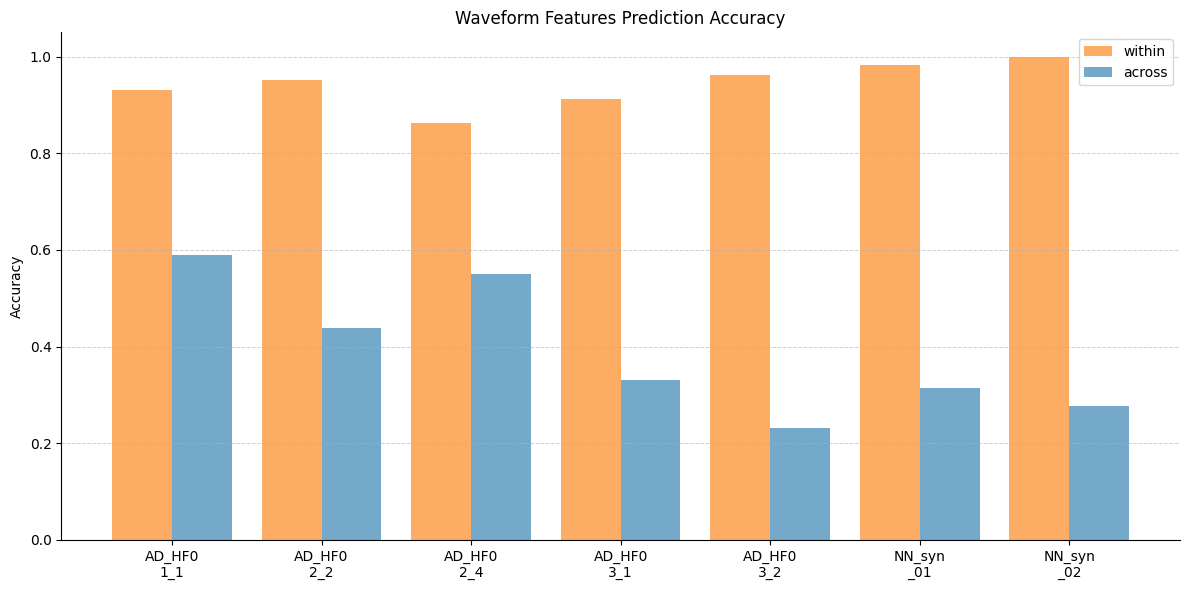

In [55]:
visualize_session_metrics([waveform_results_within,waveform_results_across], session_names, 
                          labels=['within', 'across'], colors=['#fCaC63', '#74a9ca'],
                         title='Waveform Features Prediction Accuracy')

### 3. Predict with Waveform + Distance

In [73]:
# find k closest neuron for each channel
maxWaveformChannelsIndex = np.argmax(np.abs(channel_waveforms_all[0]).max(axis=2), axis=1)
maxWaveformChannels = goodChannels_all[0][maxWaveformChannelsIndex]

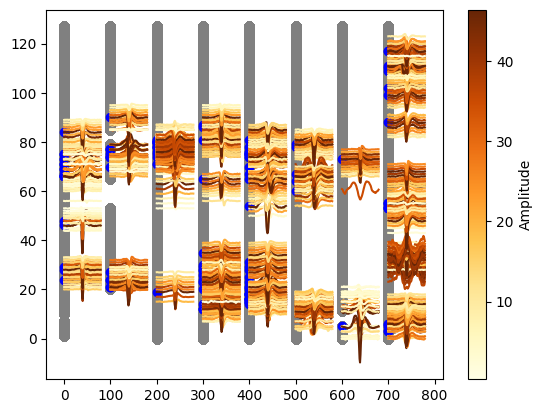

In [74]:
visualize_channel_waveform(channel_waveforms_all[0], goodChannels_all[0], maxWaveformCh_all[0],
                           n_neurons=len(channel_waveforms_all[0]), percentile=99, channel_samples=1)

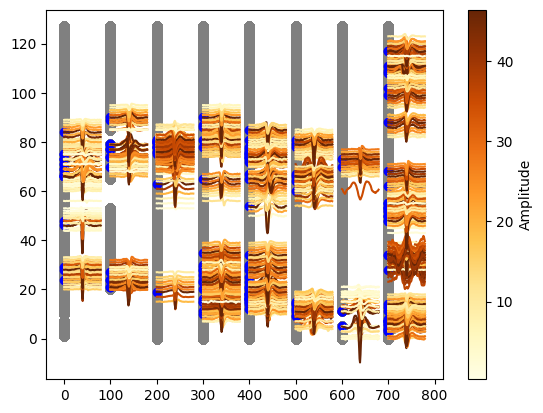

In [75]:
visualize_channel_waveform(channel_waveforms_all[0], goodChannels_all[0], maxWaveformChannels,
                           n_neurons=len(channel_waveforms_all[0]), percentile=99, channel_samples=1)

In [76]:
# check the discrepency here
np.setdiff1d(goodChannels_all[0][maxWaveformChannelsIndex], maxWaveformCh_all[0])

array([ 207,  217,  319,  394,  395,  399,  400,  462,  474,  524,  529,
        542,  546,  584,  585,  589,  597,  649,  651,  652,  654,  655,
        706,  721,  779,  838,  900,  903,  904,  907,  909,  910,  924,
        930,  944,  946,  948,  958,  964, 1004])

In [77]:
channelCoordMap = np.array([[ch // 128 * 300, ch % 128 * 30] for ch in goodChannels_all[0]])

num_channels = len(goodChannels_all[0])
distance_matrix = np.zeros((num_channels, num_channels))

for i in range(num_channels):
    for j in range(num_channels):
        distance_matrix[i, j] = np.linalg.norm(channelCoordMap[i] - channelCoordMap[j])

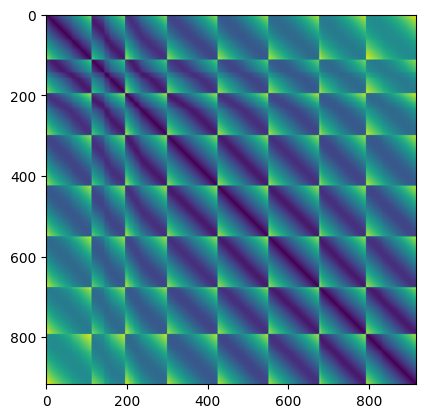

In [78]:
plt.imshow(distance_matrix)

In [29]:
channelFeaturesAll = []

for i in range(len(goodChannels_all[0])):
    ch = goodChannels_all[0][i]
    distances = distance_matrix[i]

    nearest_indices = np.argsort(distances)[:5]
    nearest_channels = goodChannels_all[0][nearest_indices]
    features = channel_waveforms_all[0][:, nearest_indices, :]
    
    max_value_per_neuron = np.max(features, axis=2)
    top_neuron_indices = np.argsort(max_value_per_neuron, axis=0)[-5:][::-1]
    
    rows = top_neuron_indices.T
    cols = np.arange(max_value_per_neuron.shape[1])
    
    channelFeatures = features[rows, cols[:, None], :] 
    channelFeaturesAll.append(channelFeatures)

In [30]:
data = np.array(channelFeaturesAll).reshape(len(channelFeaturesAll), -1)
labels = class_labels_all[0][goodChannels_all[0]]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
clf = LogisticRegression(C=0.001)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.7339699863574352
Test Accuracy: 0.5869565217391305


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4. Predict with waveforms from nearby 16 channels

In [79]:
np.argsort(distance_matrix[100])[:10]

array([100,  99, 101,  98, 102,  97, 103, 104,  96,  95])

In [15]:
def find_neighbors(ch, size=16):
    base = np.arange(ch - size//2, ch + size//2)

In [16]:
def getSpikesFeatures(waveform_features, goodChannels, distance_matrix, window_size=16):
    spikesFeaturesAll = []
    
    for i in range(len(goodChannels)):
        ch = goodChannels[i]
        distances = distance_matrix[i]
    
        nearest_indices = np.argsort(distances)[:window_size]
        features = waveform_features[:, nearest_indices, :]
    
        spikesFeaturesAll.append(features)
    
    spikesFeaturesAll = np.array(spikesFeaturesAll)
    return spikesFeaturesAll

In [82]:
spikesFeaturesAll = getSpikesFeatures(channel_waveforms_all[0], goodChannels_all[0], distance_matrix, window_size=16)

In [83]:
spikesFeaturesAll.shape

(917, 184, 16, 80)

In [85]:
data = spikesFeaturesAll.reshape(len(spikesFeaturesAll), -1)
labels = class_labels_all[0][goodChannels_all[0]]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.8478260869565217


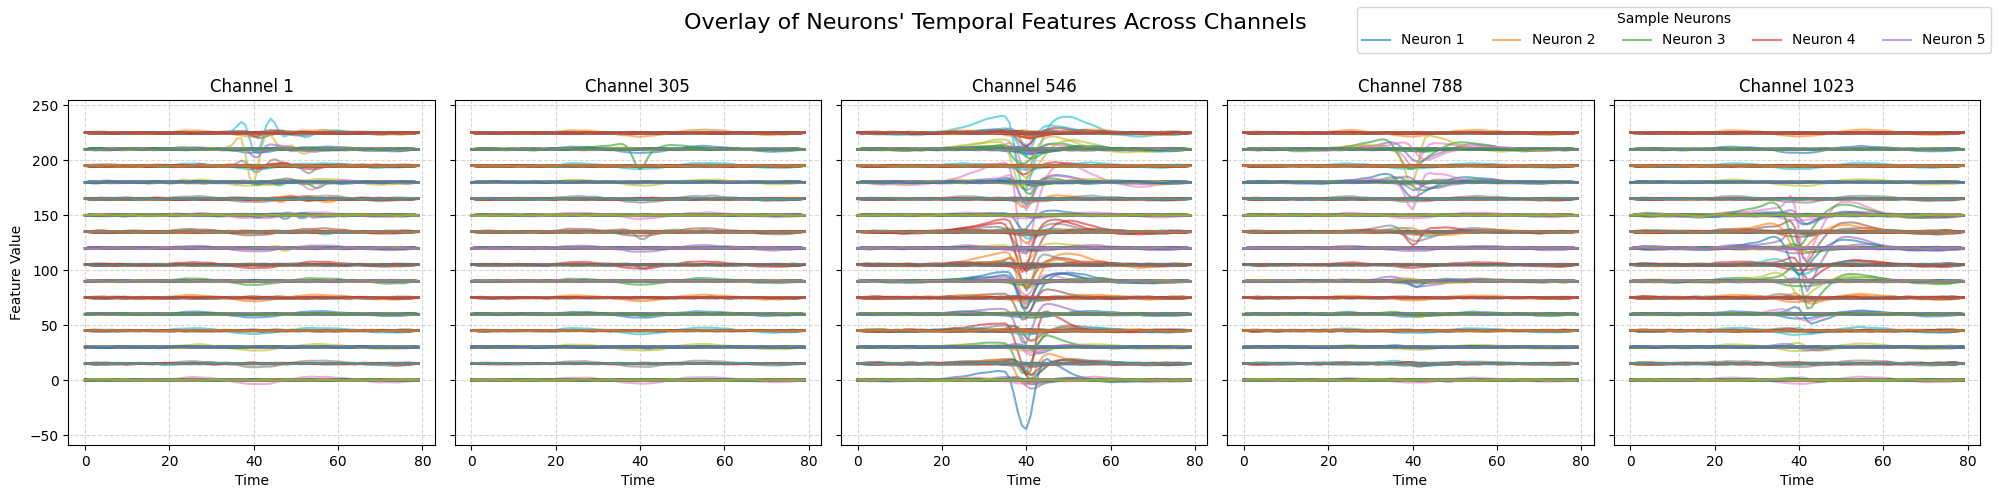

In [86]:
# visualize the 16 neighboring channels feature at selected channel at all units
n_channels_to_plot = 5
sampled_channels = np.linspace(0, spikesFeaturesAll.shape[0] - 1, n_channels_to_plot, dtype=int)

fig, axes = plt.subplots(1, n_channels_to_plot, figsize=(20, 5), sharey=True)

for i, channel_idx in enumerate(sampled_channels):
    ax = axes[i]
    
    for j in range(len(spikesFeaturesAll[channel_idx])):
        channel_data = spikesFeaturesAll[channel_idx][j]
        
        for neuron_idx in range(channel_data.shape[0]):
            ax.plot(channel_data[neuron_idx]+neuron_idx*15, alpha=0.6, label=f"Neuron {neuron_idx+1}" if neuron_idx < 5 else "")

        channel_name = goodChannels_all[0][sampled_channels][i]
        ax.set_title(f"Channel {channel_name}")
        ax.set_xlabel("Time")
        if i == 0:
            ax.set_ylabel("Feature Value")
        ax.grid(True, linestyle='--', alpha=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels[:5], ncol=5, title="Sample Neurons")
plt.suptitle("Overlay of Neurons' Temporal Features Across Channels", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [39]:
test_results = []
for i in range(len(session_names)):
    test_result = []

    channelCoordMap = np.array([[ch // 128 * 300, ch % 128 * 30] for ch in goodChannels_all[i]])

    num_channels = len(goodChannels_all[i])
    distance_matrix = np.zeros((num_channels, num_channels))
    
    for j in range(num_channels):
        for k in range(num_channels):
            distance_matrix[j, k] = np.linalg.norm(channelCoordMap[j] - channelCoordMap[k])
    
    for s in range(4, 20, 2):
        spikesFeaturesAll = getSpikesFeatures(channel_waveforms_all[i], goodChannels_all[i], distance_matrix, window_size=s)
        data = spikesFeaturesAll.reshape(len(spikesFeaturesAll), -1)
        labels = class_labels_all[i][goodChannels_all[i]]
        
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        
        y_pred_train = clf.predict(X_train)
        y_pred = clf.predict(X_test)
    
        print("Test Accuracy:", accuracy_score(y_test, y_pred))
        test_result.append(accuracy_score(y_test, y_pred))
    test_results.append(test_result)

Test Accuracy: 0.8804347826086957
Test Accuracy: 0.8641304347826086
Test Accuracy: 0.8315217391304348
Test Accuracy: 0.8478260869565217
Test Accuracy: 0.875
Test Accuracy: 0.8967391304347826
Test Accuracy: 0.8478260869565217
Test Accuracy: 0.8804347826086957


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.7566137566137566


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.7407407407407407


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.7566137566137566


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.8095238095238095


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.8095238095238095


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.7936507936507936


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.8042328042328042


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.7777777777777778
Test Accuracy: 0.8193548387096774
Test Accuracy: 0.8193548387096774
Test Accuracy: 0.8193548387096774
Test Accuracy: 0.832258064516129
Test Accuracy: 0.8451612903225807
Test Accuracy: 0.8516129032258064
Test Accuracy: 0.8580645161290322
Test Accuracy: 0.8580645161290322
Test Accuracy: 0.8113207547169812
Test Accuracy: 0.7861635220125787
Test Accuracy: 0.7924528301886793
Test Accuracy: 0.8238993710691824
Test Accuracy: 0.7987421383647799
Test Accuracy: 0.8176100628930818
Test Accuracy: 0.7987421383647799
Test Accuracy: 0.7987421383647799
Test Accuracy: 0.9290322580645162
Test Accuracy: 0.9354838709677419
Test Accuracy: 0.9225806451612903
Test Accuracy: 0.9354838709677419
Test Accuracy: 0.9225806451612903
Test Accuracy: 0.9354838709677419
Test Accuracy: 0.9419354838709677
Test Accuracy: 0.9225806451612903
Test Accuracy: 0.9264705882352942
Test Accuracy: 0.9509803921568627
Test Accuracy: 0.9313725490196079
Test Accuracy: 0.9362745098039216
Test Accuracy: 

In [41]:
test_results = np.array(test_results)
print(test_results.shape)

(7, 8)


In [87]:
test_results = np.array([[0.88043478, 0.86413043, 0.83152174, 0.84782609, 0.875     ,
        0.89673913, 0.84782609, 0.88043478],
       [0.75661376, 0.74074074, 0.75661376, 0.80952381, 0.80952381,
        0.79365079, 0.8042328 , 0.77777778],
       [0.81935484, 0.81935484, 0.81935484, 0.83225806, 0.84516129,
        0.8516129 , 0.85806452, 0.85806452],
       [0.81132075, 0.78616352, 0.79245283, 0.82389937, 0.79874214,
        0.81761006, 0.79874214, 0.79874214],
       [0.92903226, 0.93548387, 0.92258065, 0.93548387, 0.92258065,
        0.93548387, 0.94193548, 0.92258065],
       [0.92647059, 0.95098039, 0.93137255, 0.93627451, 0.95098039,
        0.93627451, 0.93627451, 0.94607843],
       [0.90640394, 0.89162562, 0.86699507, 0.8817734 , 0.89655172,
        0.87684729, 0.86699507, 0.87684729]])

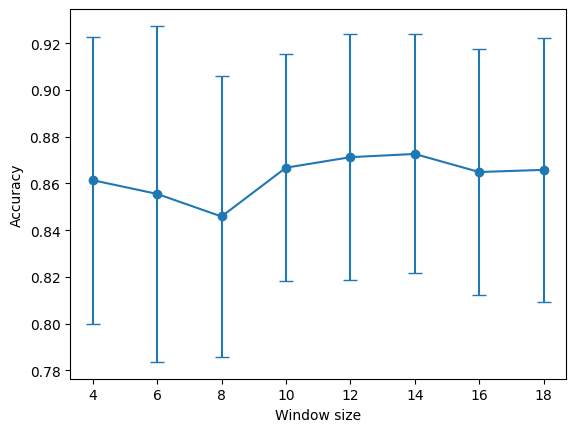

In [88]:
mean_accuracies = np.mean(test_results, axis=0)
std_accuracies = np.std(test_results, axis=0)
plt.errorbar(np.arange(4, 20, 2), mean_accuracies, yerr=std_accuracies, fmt='-o', capsize=5, label="Accuracy over different window size")
plt.ylabel("Accuracy")
plt.xlabel("Window size")
plt.show()

In [89]:
spikesFeaturePerSession = []

for i in range(len(session_names)):
    channelCoordMap = np.array([[ch // 128 * 300, ch % 128 * 30] for ch in goodChannels_all[i]])
    num_channels = len(goodChannels_all[i])
    distance_matrix = np.zeros((num_channels, num_channels))
    class_labels_good_channels = class_labels_all[i][goodChannels_all[i]]

    for j in range(num_channels):
        for k in range(num_channels):
            distance_matrix[j, k] = np.linalg.norm(channelCoordMap[j] - channelCoordMap[k])
    
    spikesFeaturesAll = getSpikesFeatures(channel_waveforms_all[i], goodChannels_all[i], distance_matrix, window_size=16)
    n_channels, n_units, n_neighbors, n_times = spikesFeaturesAll.shape
    
    reshaped_tensor = spikesFeaturesAll.transpose(0, 2, 3, 1).reshape(-1, n_units) 
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(reshaped_tensor)
    result_tensor = pca_result.reshape(n_channels, n_neighbors, n_times, 50).transpose(0, 3, 1, 2) 
    result_tensor = result_tensor[class_labels_good_channels != 5]
    
    spikesFeaturePerSession.append(result_tensor)

In [90]:
index_train, index_test = train_test_split(np.arange(len(session_names)), test_size=0.2, random_state=42)

X_train = np.concatenate([spikesFeaturePerSession[i] for i in index_train], axis=0)
X_test = np.concatenate([spikesFeaturePerSession[i] for i in index_test], axis=0)

X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

y_train = np.hstack([channel_labels_all[i] for i in index_train])
y_test = np.hstack([channel_labels_all[i] for i in index_test])

In [91]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2046, 64000) (1162, 64000) (2046,) (1162,)


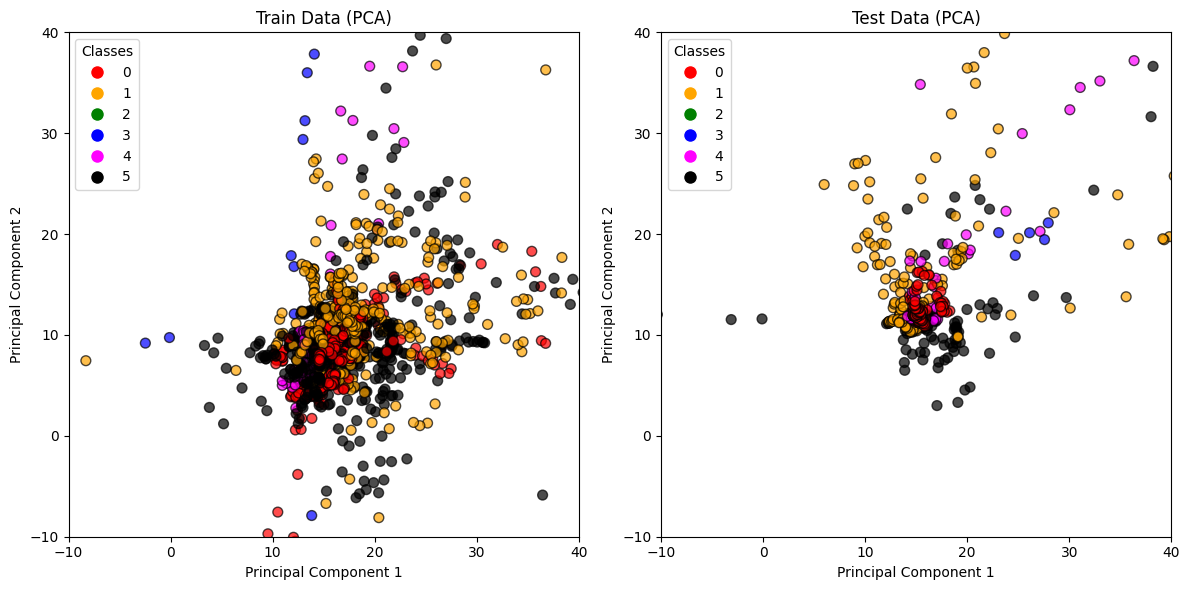

In [92]:
from matplotlib.colors import ListedColormap

color_names = ["red", "orange", "green", "blue", "magenta", "black"]
cmap = ListedColormap(color_names)

train_colors = [color_names[y] for y in y_train]
test_colors = [color_names[y] for y in y_test]

pca = PCA(n_components=2)
pca_train_result = pca.fit_transform(X_train)
pca_test_result = pca.transform(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(pca_train_result[:, 0], pca_train_result[:, 1], c=y_train, cmap=cmap, alpha=0.7, edgecolor='k', s=50)
axes[0].set_title("Train Data (PCA)")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in enumerate(color_names)], 
               title="Classes", loc="best")
axes[0].set_xlim(-10, 40)
axes[0].set_ylim(-10, 40)

axes[1].scatter(pca_test_result[:, 0], pca_test_result[:, 1], c=y_test, cmap=cmap, alpha=0.7, edgecolor='k', s=50)
axes[1].set_title("Test Data (PCA)")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in enumerate(color_names)], 
               title="Classes", loc="best")
axes[1].set_xlim(-10, 40)
axes[1].set_ylim(-10, 40)

plt.tight_layout()
plt.show()

In [93]:
clf = LogisticRegression(C=1e-5)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.8660801564027371
Test Accuracy: 0.4578313253012048


In [97]:
spatial_waveform_results = []

for i in range(len(session_names)):
    index_test = np.array([i])
    index_train = np.setdiff1d(np.arange(len(session_names)), index_test)
    X_train = np.concatenate([spikesFeaturePerSession[i] for i in index_train], axis=0)
    X_test = np.concatenate([spikesFeaturePerSession[i] for i in index_test], axis=0)
    
    X_train = X_train.reshape(len(X_train), -1)
    X_test = X_test.reshape(len(X_test), -1)
    
    y_train = np.hstack([channel_labels_all[i] for i in index_train])
    y_test = np.hstack([channel_labels_all[i] for i in index_test])

    clf = LogisticRegression(C=1e-4)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    spatial_waveform_results.append(accuracy_score(y_test, y_pred))

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.10510046367851623


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.3262135922330097


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.15010570824524314


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.41887905604719766


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.23846153846153847


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.12432432432432433
Test Accuracy: 0.23132969034608378


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


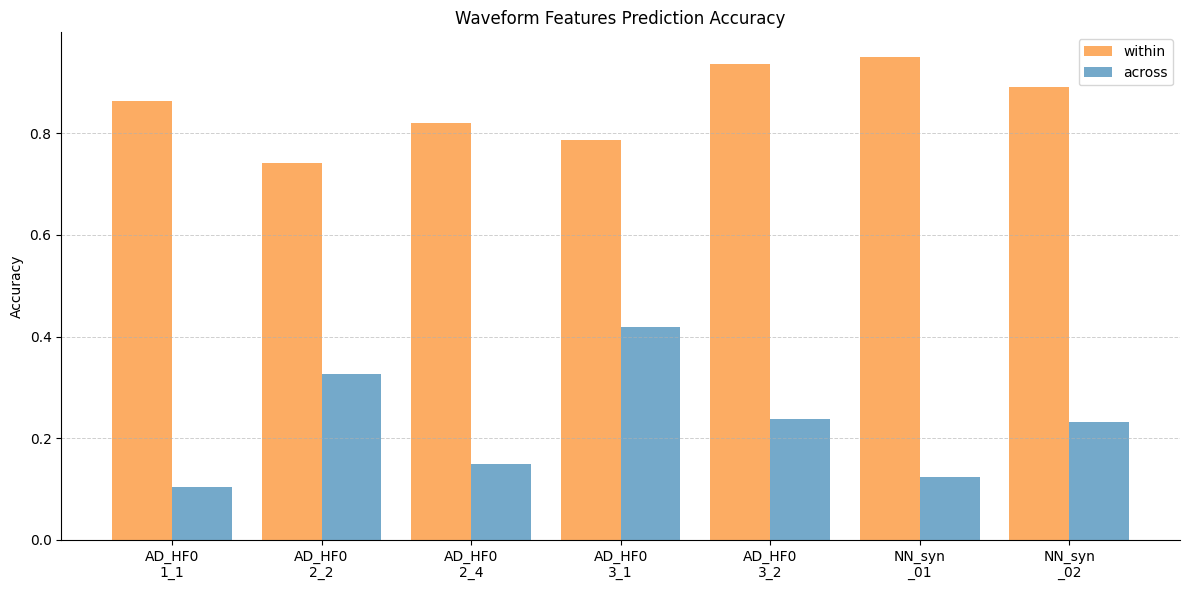

In [98]:
visualize_session_metrics([test_results[:, 1],spatial_waveform_results], session_names, 
                          labels=['within', 'across'], colors=['#fCaC63', '#74a9ca'],
                         title='Waveform Features Prediction Accuracy')

### 5. Predict from "averaged" waveforms using clustered waveforms

In [17]:
channelCoordMap = np.array([[ch // 128 * 300, ch % 128 * 30] for ch in goodChannels_all[0]])

num_channels = len(goodChannels_all[0])
distance_matrix = np.zeros((num_channels, num_channels))

for i in range(num_channels):
    for j in range(num_channels):
        distance_matrix[i, j] = np.linalg.norm(channelCoordMap[i] - channelCoordMap[j])
        
spikesFeaturesAll = getSpikesFeatures(channel_waveforms_all[0], goodChannels_all[0], distance_matrix, window_size=16)

In [18]:
channel_waveforms_all[0].shape

(184, 917, 80)

In [19]:
# for each channel, find the unit with maxwaveform, and cluster it in 2d
# n_units, n_channels, n_times = channel_waveforms_all[0].shape
# waveforms = []
# maxWaveformUnitsIndex = np.argmax(np.abs(channel_waveforms_all[0]).max(axis=2), axis=0)

# for i in range(n_channels):
#     waveform = channel_waveforms_all[0][maxWaveformUnitsIndex[i]][i]
#     waveforms.append(waveform)

# pca = PCA(n_components=2)
# pca.fit(waveforms)
# reshaped_data = channel_waveforms_all[0].reshape(-1, n_time)
# pca_result = pca.transform(reshaped_data)
# pca_result_reshaped = pca_result.reshape(n_units, n_channels, 2)

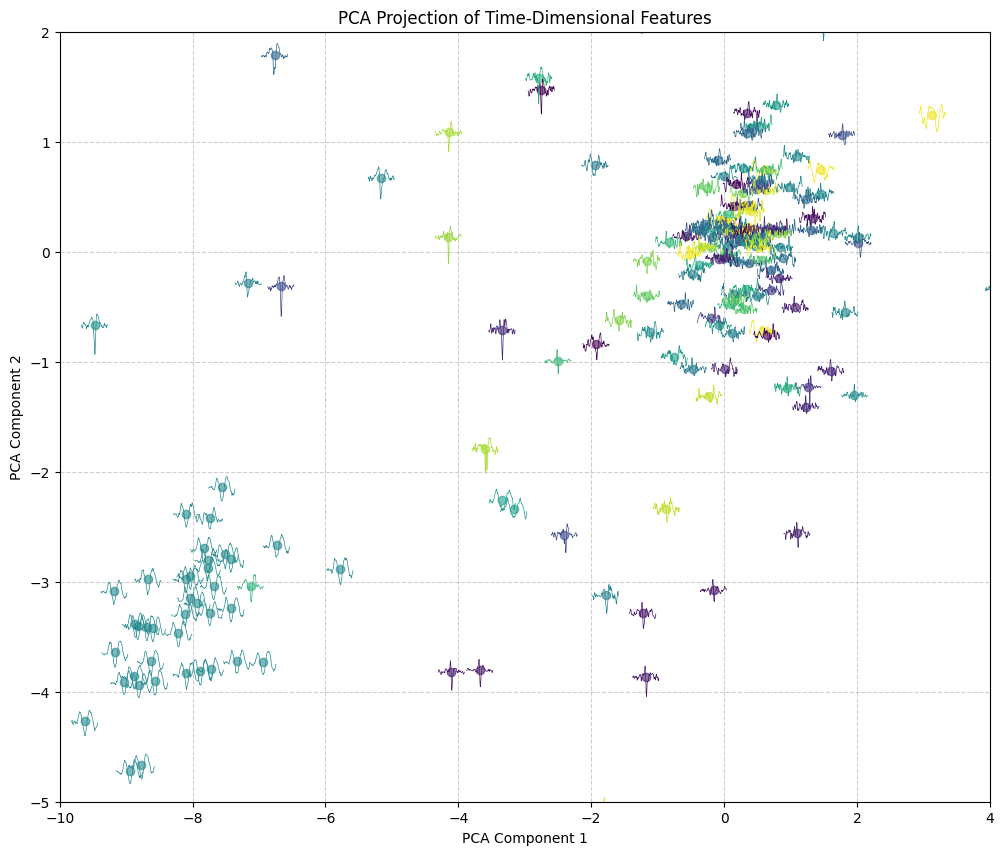

In [20]:
# compute PCA of waveforms of all units from all channels colored by cell id
# visualize only waveforms of top 5 units for each channel (randomly selected 50)

n_units, n_channels, n_time = channel_waveforms_all[0].shape
reshaped_data = channel_waveforms_all[0].reshape(-1, n_time)

cmap = plt.get_cmap("viridis", n_units)
unit_colors = [cmap(unit_idx) for unit_idx in range(n_units)] 
top_5_indices = np.argsort(np.max(channel_waveforms_all[0], axis=2), axis=0)[-5:]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(reshaped_data)
pca_result_reshaped = pca_result.reshape(n_units, n_channels, 2)

fig, ax = plt.subplots(figsize=(12, 10))

n_display_channels = 50  # Number of channels to display
np.random.seed(42)
random_channels = np.random.choice(n_channels, n_display_channels, replace=False)

for channel_idx in random_channels:
    for unit_idx in top_5_indices[:, channel_idx]:
        x, y = pca_result_reshaped[unit_idx, channel_idx]
        
        ax.scatter(x, y, alpha=0.6, color=unit_colors[unit_idx], label=f"Unit {unit_idx}, Channel {channel_idx}" if (unit_idx, channel_idx) == (0, 0) else "")
        
        waveform = channel_waveforms_all[0][unit_idx, channel_idx]
        ax.plot(np.arange(len(waveform))/200+x-len(waveform)/400, waveform/max(waveform)/10+y, lw=0.5, color=unit_colors[unit_idx])

ax.set_title("PCA Projection of Time-Dimensional Features")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.grid(True, linestyle="--", alpha=0.6)
plt.xlim(-10, 4)
plt.ylim(-5, 2)
plt.show()

In [21]:
n_units, n_channels, n_times = channel_waveforms_all[0].shape
waveforms = []
maxWaveformChannelIndex = np.argmax(np.abs(channel_waveforms_all[0]).max(axis=2), axis=1)

for i in range(n_units):
    waveform = channel_waveforms_all[0][i][maxWaveformChannelIndex[i]]
    waveforms.append(waveform)

waveforms = np.array(waveforms)

In [22]:
waveforms.shape

(184, 80)

In [23]:
min_vals = np.min(waveforms, axis=1, keepdims=True)
max_vals = np.max(waveforms, axis=1, keepdims=True)
normalized_waveforms = waveforms / (max_vals - min_vals)

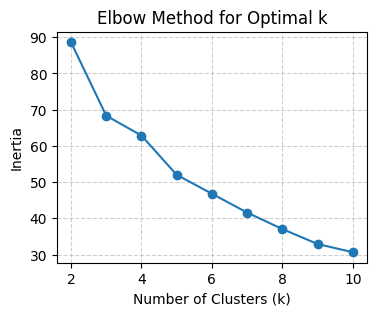

In [24]:
from sklearn.cluster import KMeans

inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_waveforms)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(4, 3))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.grid(alpha=0.6, linestyle="--")
plt.show()

In [25]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_waveforms)

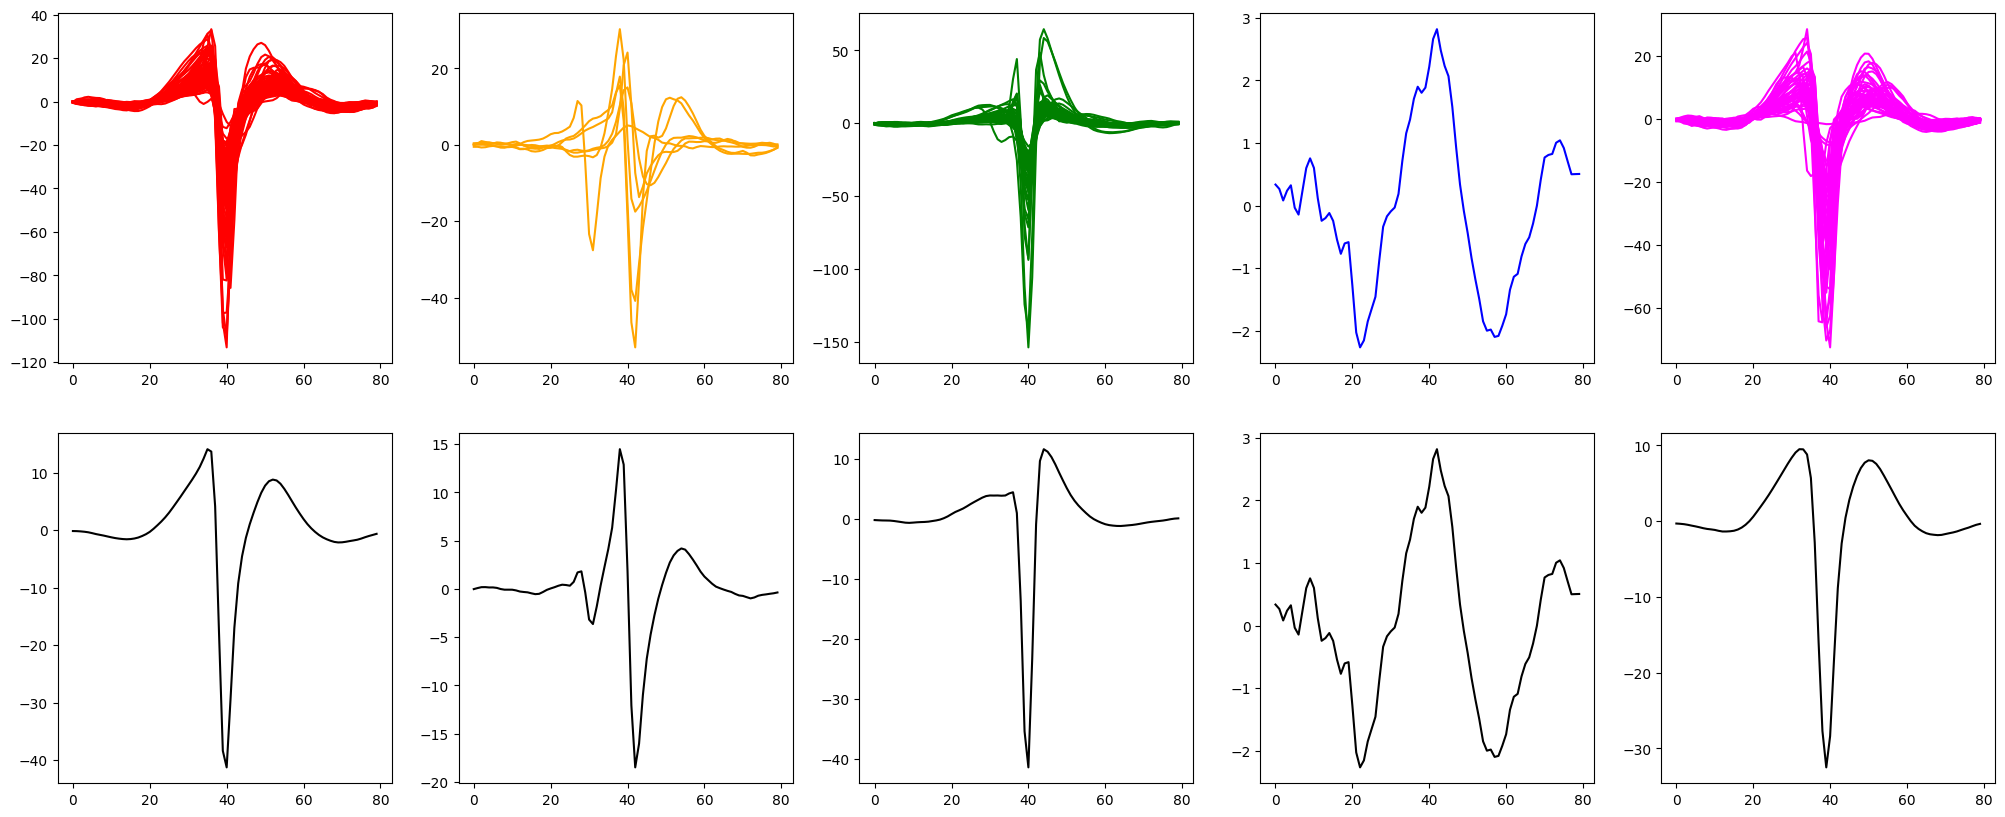

In [26]:
plt.figure(figsize=(25, 10))
for r in range(5):
    plt.subplot(2, 5, r+1)
    for i in range(len(normalized_waveforms)):
        if cluster_labels[i] == r:
            plt.plot(waveforms[i], c=color_names[r])
for r in range(5):
    plt.subplot(2, 5, r+6)
    mean_waveforms = np.mean(waveforms[cluster_labels == r], axis=0)
    plt.plot(mean_waveforms, c='black')

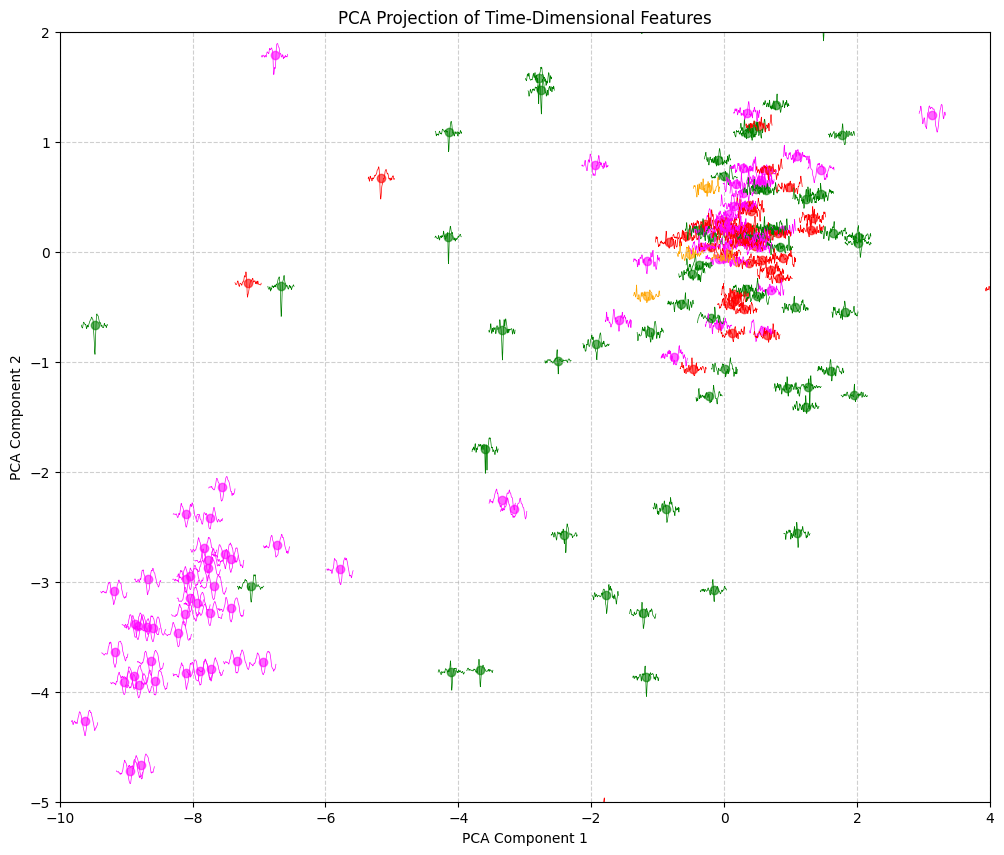

In [27]:
# compute PCA of waveforms of all units from all channels colored by cluster id
# visualize only waveforms of top 5 units for each channel (randomly selected 50)

n_units, n_channels, n_time = channel_waveforms_all[0].shape
reshaped_data = channel_waveforms_all[0].reshape(-1, n_time)

unit_colors = [color_names[cluster_labels[unit_idx]] for unit_idx in range(n_units)] 
top_5_indices = np.argsort(np.max(channel_waveforms_all[0], axis=2), axis=0)[-5:]

fig, ax = plt.subplots(figsize=(12, 10))

for channel_idx in random_channels:
    for unit_idx in top_5_indices[:, channel_idx]:
        x, y = pca_result_reshaped[unit_idx, channel_idx]
        
        ax.scatter(x, y, alpha=0.6, color=unit_colors[unit_idx], label=f"Unit {unit_idx}, Channel {channel_idx}" if (unit_idx, channel_idx) == (0, 0) else "")
        
        waveform = channel_waveforms_all[0][unit_idx, channel_idx]
        ax.plot(np.arange(len(waveform))/200+x-len(waveform)/400, waveform/max(waveform)/10+y, lw=0.5, color=unit_colors[unit_idx])

ax.set_title("PCA Projection of Time-Dimensional Features")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.grid(True, linestyle="--", alpha=0.6)
plt.xlim(-10, 4)
plt.ylim(-5, 2)
plt.show()

In [28]:
def cell_to_cluster(channel_features, cluster_labels):
    n_units, n_channels, n_time = channel_features.shape
    n_clusters = len(np.unique(cluster_labels))
    
    channel_features_new = np.zeros((n_clusters, n_channels, n_time))
    for c in range(n_clusters):
        cluster_indices = np.where(cluster_labels == c)[0]
        channel_features_new[c] = np.mean(channel_features[cluster_indices], axis=0)
    return channel_features_new

In [29]:
agg_waveforms = cell_to_cluster(channel_waveforms_all[0], cluster_labels)
agg_waveforms = agg_waveforms.transpose(1, 0, 2).reshape(agg_waveforms.shape[1], -1)
class_labels_good_channels = class_labels_all[0][goodChannels_all[0]]

print("n_neurons, n_channels, n_time: ", agg_waveforms.shape)
print("n_labels: ", class_labels_good_channels.shape)

n_neurons, n_channels, n_time:  (917, 400)
n_labels:  (917,)


In [30]:
data = agg_waveforms[class_labels_good_channels != 5]
labels = class_labels_good_channels[class_labels_good_channels != 5]

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.9400386847195358
Test Accuracy: 0.7846153846153846


In [31]:
def get_cluster_labels(channel_waveforms, n_clusters=5):
    n_units, n_channels, n_times = channel_waveforms.shape
    waveforms = []
    maxWaveformChannelIndex = np.argmax(np.abs(channel_waveforms).max(axis=2), axis=1)
    
    for i in range(n_units):
        waveform = channel_waveforms[i][maxWaveformChannelIndex[i]]
        waveforms.append(waveform)
    
    waveforms = np.array(waveforms)
    
    min_vals = np.min(waveforms, axis=1, keepdims=True)
    max_vals = np.max(waveforms, axis=1, keepdims=True)
    normalized_waveforms = waveforms / (max_vals - min_vals)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_waveforms)
    return cluster_labels

In [32]:
agg_channel_features_all = []
channel_labels_all = []

for i in range(len(channel_waveforms_all)):
    cluster_labels = get_cluster_labels(channel_waveforms_all[i], n_clusters=5)
    agg_waveforms = cell_to_cluster(channel_waveforms_all[i], cluster_labels)
    agg_waveforms = agg_waveforms.transpose(1, 0, 2).reshape(agg_waveforms.shape[1], -1)

    class_labels_good_channels = class_labels_all[i][goodChannels_all[i]]
    data = agg_waveforms[class_labels_good_channels != 5]
    labels = class_labels_good_channels[class_labels_good_channels != 5]

    agg_channel_features_all.append(data)
    channel_labels_all.append(labels)

In [33]:
index_train, index_test = train_test_split(np.arange(len(session_names)), test_size=0.2, random_state=42)

X_train = np.vstack([agg_channel_features_all[i] for i in index_train])
X_test = np.vstack([agg_channel_features_all[i] for i in index_test])

y_train = np.hstack([channel_labels_all[i] for i in index_train])
y_test = np.hstack([channel_labels_all[i] for i in index_test])

In [34]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2046, 400) (1162, 400) (2046,) (1162,)


In [35]:
clf = LogisticRegression(C=1e-2)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.5254154447702835
Test Accuracy: 0.5060240963855421


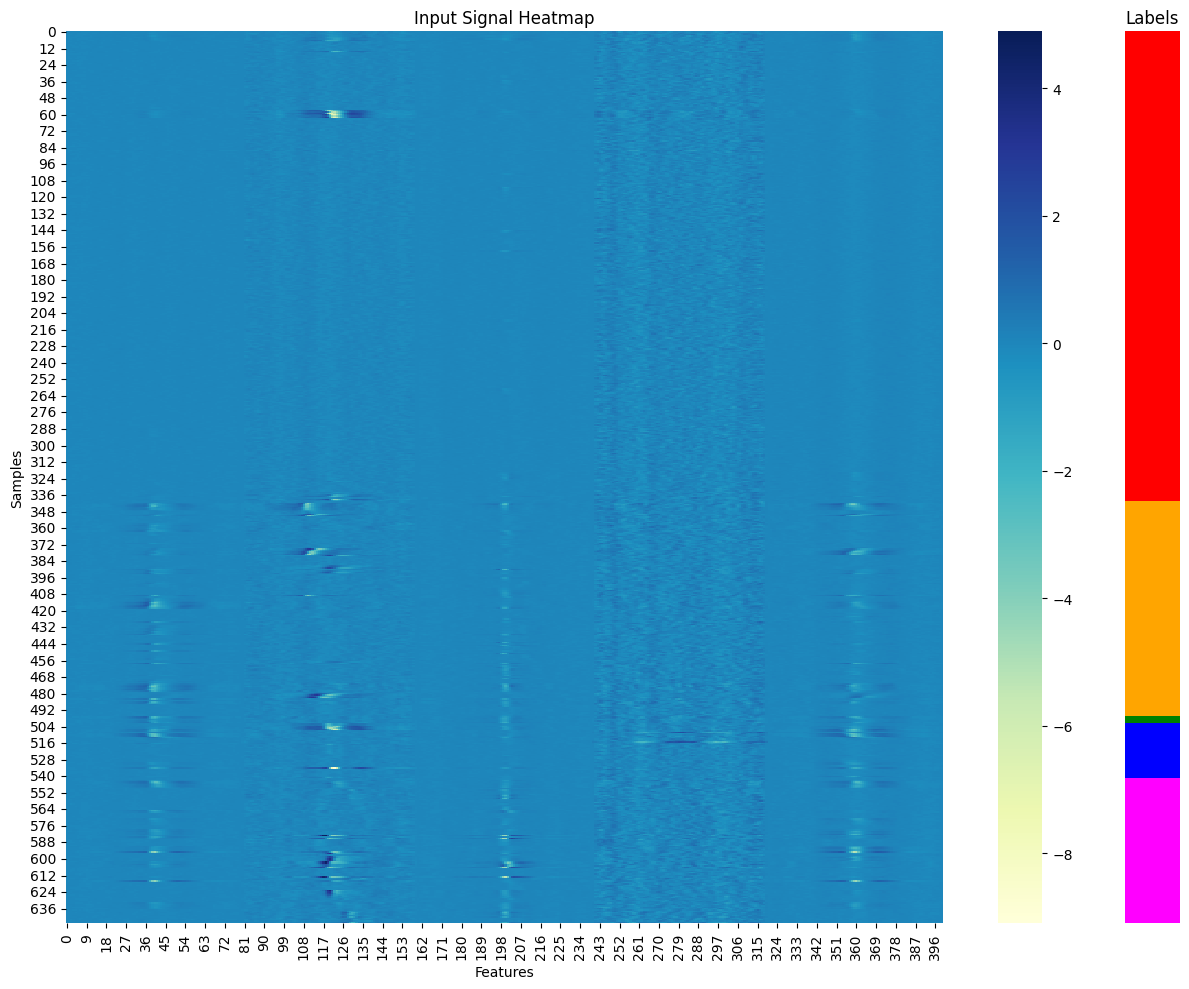

In [46]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(1, 2, figsize=(12, 10), gridspec_kw={'width_ratios': [20, 1]})
session_idx = 0

sorted_index = np.argsort(channel_labels_all[session_idx])

sns.heatmap(agg_channel_features_all[session_idx][sorted_index], ax=ax[0], cmap="YlGnBu", cbar=True)
ax[0].set_title("Input Signal Heatmap")
ax[0].set_xlabel("Features")
ax[0].set_ylabel("Samples")

label_colors = color_names[:-1]
cmap = ListedColormap(color_names[:-1])
sns.heatmap(np.array(channel_labels_all[session_idx])[sorted_index].reshape(-1, 1), ax=ax[1], cmap=sns.color_palette(label_colors, as_cmap=True),
            cbar=False, xticklabels=False, yticklabels=False)

ax[1].set_title("Labels")
ax[1].set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.show()

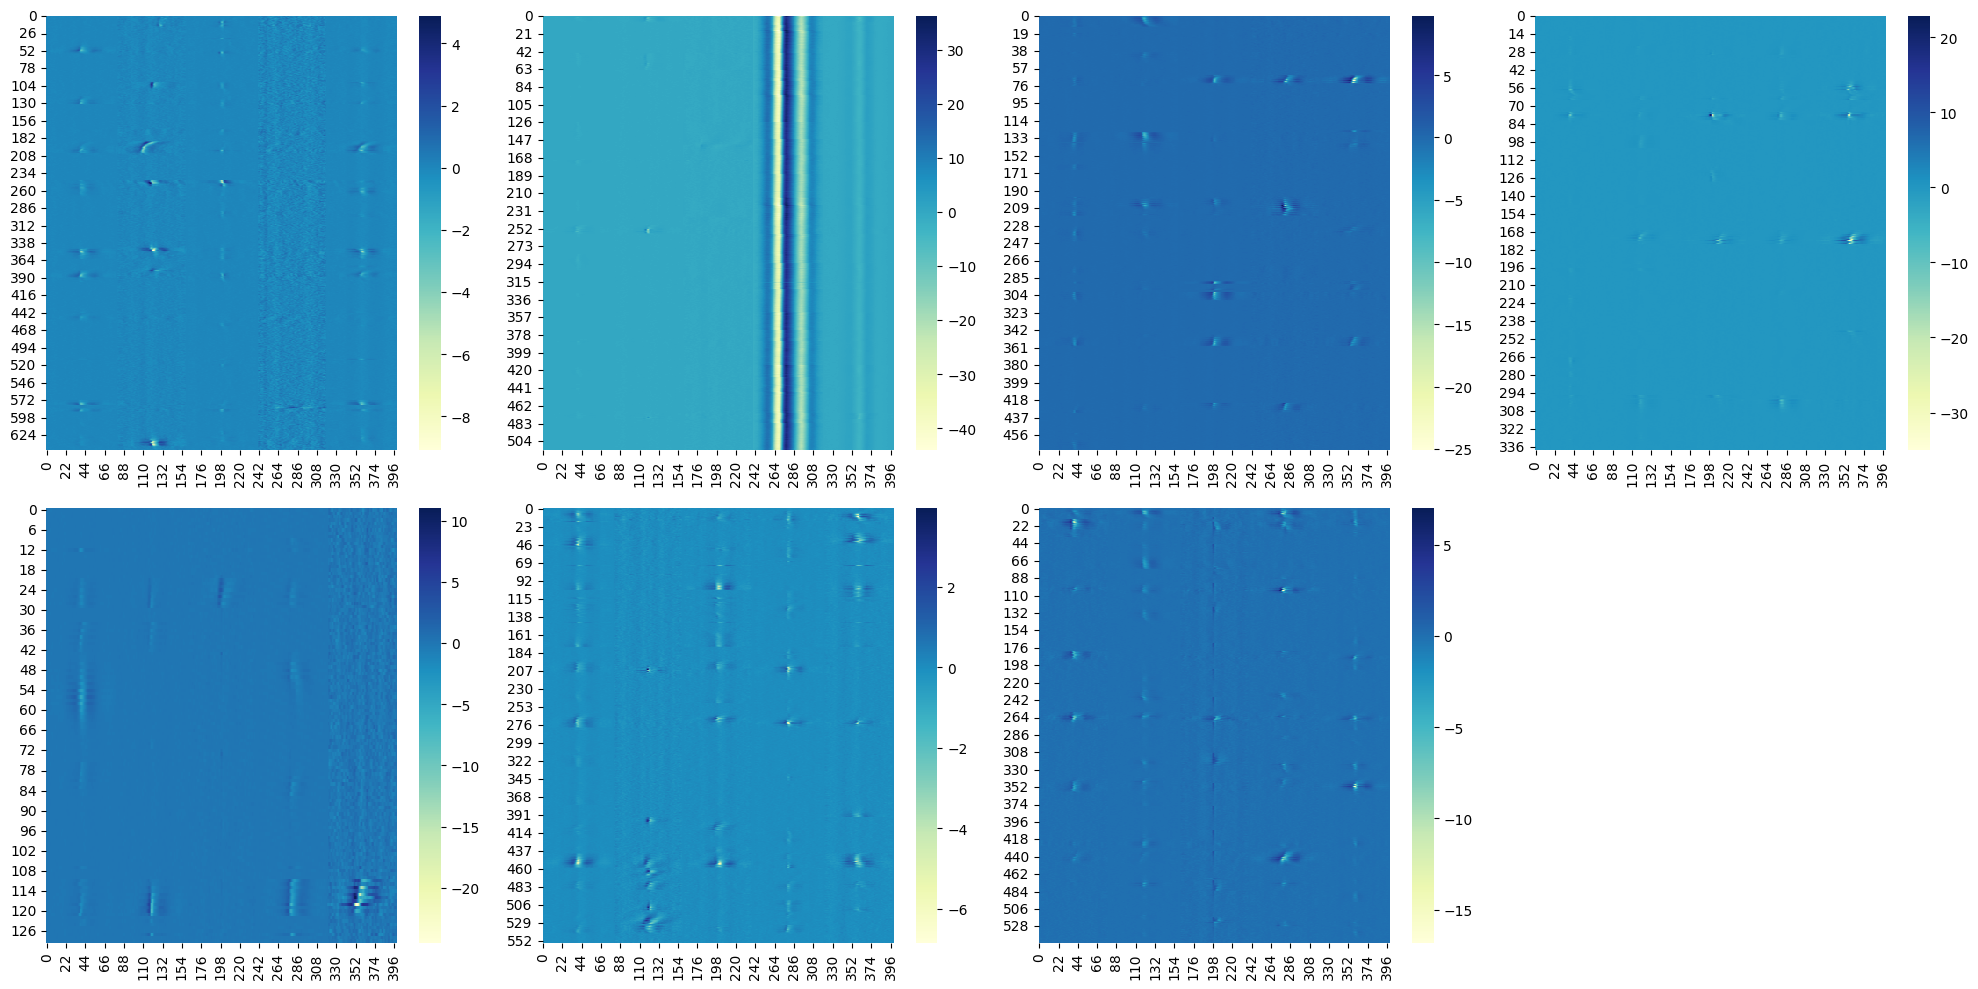

In [35]:
all_values = np.concatenate([matrix.flatten() for matrix in agg_channel_features_all])
# vmin, vmax = all_values.min(), all_values.max()

plt.figure(figsize=(20, 10))
for i in range(len(session_names)):
    plt.subplot(2, 4, i+1)
    sns.heatmap(agg_channel_features_all[i], fmt="d", cmap="YlGnBu")
plt.tight_layout()

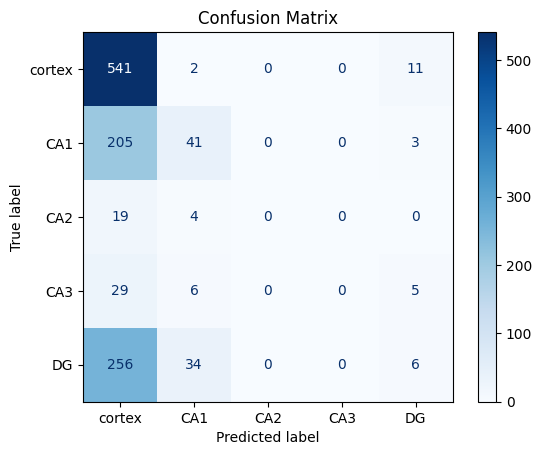

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=brain_regions)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [114]:
agg_waveform_within = []

for i in range(len(session_names)):
    data = agg_channel_features_all[i]
    labels = channel_labels_all[i]

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    agg_waveform_within.append(accuracy_score(y_test, y_pred))

Test Accuracy: 0.7846153846153846
Test Accuracy: 0.6990291262135923
Test Accuracy: 0.6947368421052632
Test Accuracy: 0.6911764705882353
Test Accuracy: 0.7307692307692307
Test Accuracy: 0.7477477477477478
Test Accuracy: 0.8727272727272727


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [118]:
agg_waveform_across = []

for index_test in range(len(channel_waveforms_all)):
    index_tests = np.array([index_test])
    index_train = np.setdiff1d(np.arange(len(channel_waveforms_all)) , index_tests) 
    X_train = np.vstack([agg_channel_features_all[i] for i in index_train])
    X_test = np.vstack([agg_channel_features_all[i] for i in index_tests])

    y_train = np.hstack([channel_labels_all[i] for i in index_train])
    y_test = np.hstack([channel_labels_all[i] for i in index_tests])

    clf = LogisticRegression(C=1e-4)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    agg_waveform_across.append(accuracy_score(y_test, y_pred))

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.5502318392581144
Test Accuracy: 0.41359223300970877


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Test Accuracy: 0.5010570824524313
Test Accuracy: 0.2713864306784661


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Test Accuracy: 0.2230769230769231
Test Accuracy: 0.35135135135135137
Test Accuracy: 0.3442622950819672


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


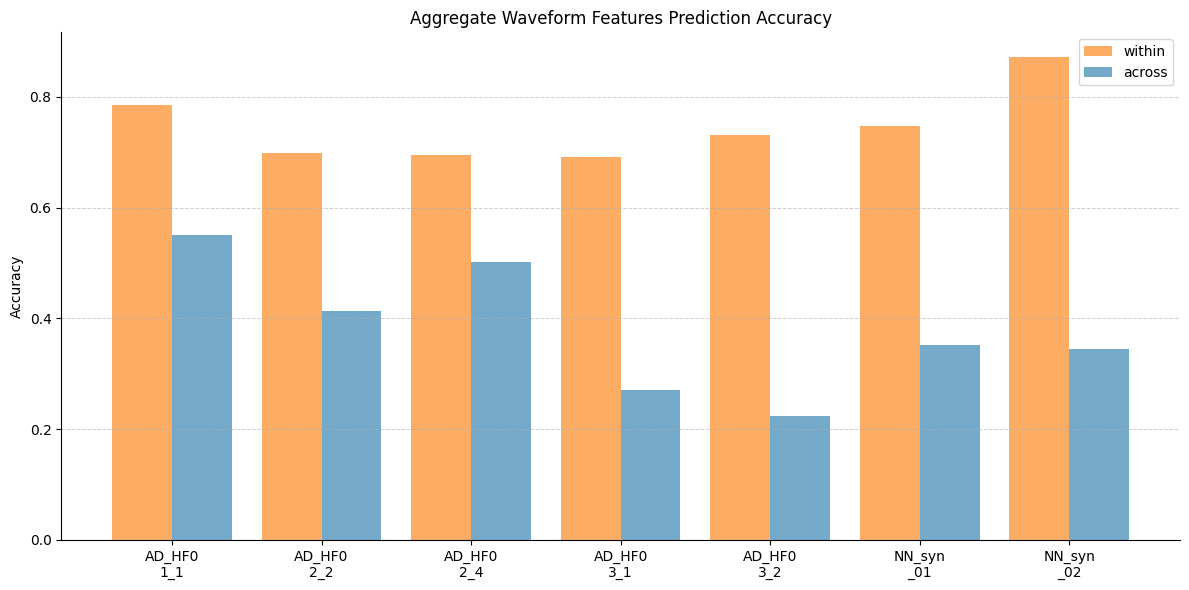

In [119]:
visualize_session_metrics([agg_waveform_within,agg_waveform_across], session_names, 
                          labels=['within', 'across'], colors=['#fCaC63', '#74a9ca'],
                         title='Aggregate Waveform Features Prediction Accuracy')

### 3.Load Raw LFP signal

In [16]:
pickle_path = f'/scratch/cl7201/shared/Neuronexus/spectrogram'
sessions=['AD_HF01_1']

In [32]:
def load_preprocessed_data(pickle_path, file_path):
    features, labels, trials = {}, {}, {}
    for session in file_path:
        data = pickle.load(open(f"{pickle_path}/{session}_raw.pickle", 'rb'))
        # data = pickle.load(open(f"{pickle_path}/{session}_lfp.pickle", 'rb'))
        X, y, trial_idx = zip(*[(d[0], d[1], d[2]) for d in data])
        features[session] = np.array(X)
        labels[session] = np.array(y, dtype=int)
        trials[session] = np.array(trial_idx)

        non_zero_indices = [i for i, x in enumerate(features[session]) if not np.all(x == 0)]

        features[session] = features[session][non_zero_indices]
        labels[session] = labels[session][non_zero_indices]
        trials[session] = trials[session][non_zero_indices]

        # Sanity check
        assert len(features[session]) == len(labels[session]) == len(trials[session]), \
            f"Inconsistent data sizes for session {session}"

    return features, labels, trials

In [33]:
channel_features_all, channel_labels_all, channel_trials_all = load_preprocessed_data(pickle_path, sessions)

In [24]:
features = channel_features_all.get(sessions[0])
labels = channel_labels_all.get(sessions[0])
trials = channel_trials_all.get(sessions[0])

In [28]:
features.shape

(38820, 60000)

In [29]:
class CLIPDataset(Dataset):
    def __init__(self, raw_signal, labels, nperseg=2048, spectrogram_size=500, transform=None, library='pytorch',
                 time_bins=None, vit=False):
        self.raw_signal = torch.tensor(raw_signal, dtype=torch.float32)
        self.labels = torch.tensor(labels)
        self.library = library
        self.sample_rate = 20000  # Make sure to change this according to the sampling rate of the data
        self.n_channels, self.n_features = raw_signal.shape

        # Calculate hop_length based on the desired number of time_bins
        self.time_bins = time_bins
        self.nperseg = nperseg
        self.hop_length = self.n_features // (self.time_bins - 1)
        self.spectrogram_size = spectrogram_size
        self.transform = transform

        # Precompute spectrograms and augmented spectrograms to save time during training and inference
        self.spectrograms, self.augmented_spectrograms = self._compute_spectrogram(self.raw_signal,
                                                                                   spectrogram_size, self.time_bins)
        
        self.visualize_spectrograms(self.spectrograms, self.augmented_spectrograms, shape=(spectrogram_size, time_bins))
        self.visualize_mel_spectrograms(self.raw_signal)

    def _compute_spectrogram(self, raw_signal, spectrogram_size, timebins):
        spectrograms = torch.zeros((self.n_channels, spectrogram_size * timebins))
        augmented_spectrograms = torch.zeros((self.n_channels, spectrogram_size * timebins))

        for channel_idx in range(self.n_channels):
            data = raw_signal[channel_idx]
            if self.library is None or self.library == 'pytorch':
                spectrogram = self._pytorch_spectrogram(data)
            elif self.library == 'librosa':
                spectrogram = self._librosa_spectrogram(data)
            elif self.library == 'scipy':
                spectrogram = self._scipy_spectrogram(data)
            spectrogram = spectrogram[:spectrogram_size]
            ##### key update that makes the Neuronexus performance improves
            # spectrogram = zscore(spectrogram, axis=0)
            spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
            spectrograms[channel_idx] = spectrogram.flatten()

            augmented_spectrogram = self.temporal_masking(spectrogram)
            augmented_spectrograms[channel_idx] = augmented_spectrogram.flatten()

        return spectrograms, augmented_spectrograms

    def _pytorch_spectrogram(self, data):
        # Use the torchaudio library for spectrogram computation
        spectrogram_transform = torchaudio.transforms.Spectrogram(
            n_fft=self.nperseg, win_length=self.nperseg, hop_length=self.hop_length, power=2.0
        )
        return 10 * torch.log10(spectrogram_transform(data))

    def _librosa_spectrogram(self, data):
        # Use librosa for spectrogram computation
        spectrogram = librosa.stft(data.numpy(), n_fft=self.nperseg, hop_length=self.hop_length,
                                   win_length=self.nperseg)
        spectrogram = np.abs(spectrogram) ** 2
        epsilon = 1e-10
        spectrogram = 10 * np.log10(spectrogram + epsilon)
        ## update librosa computation as numpy output
        # spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        return spectrogram

    def __len__(self):
        return self.n_channels

    def add_gaussian_noise(self, signal):
        return signal + torch.randn_like(signal) * 0.01

    def __getitem__(self, index):
        channel_idx = index % self.n_channels

        spectrograms = self.spectrograms[channel_idx]
        augmented_spectrograms = self.augmented_spectrograms[channel_idx]

        label = self.labels[channel_idx]

        return (spectrograms, augmented_spectrograms), label

    def visualize_spectrograms(self, spectrograms, augmented_spectrograms, shape):
        # Function to save spectrogram
        def save_spectrogram(spectrogram_data, suffix):
            spectrogram = spectrogram_data[0].reshape((shape[0], shape[1]))
            frequencies = np.arange(0, shape[0])

            time_steps = np.linspace(0, 3, shape[1])

            plt.figure(figsize=(6, 6))
            plt.pcolormesh(time_steps, frequencies, spectrogram, shading='gouraud')
            plt.ylim(0, shape[0])
            plt.colorbar(label='Intensity [dB]')
            plt.xlabel('Time [s]')
            plt.ylabel('Frequency [Hz]')
            plt.title(f'{suffix} Spectrogram - Normal Scale')
            plt.tight_layout()
            plt.savefig(f'../results/{suffix}_spectrogram_normal.png')

        # Save normal spectrogram
        save_spectrogram(spectrograms, 'normal')

        # Save Mel spectrogram
        save_spectrogram(augmented_spectrograms, 'augmented')

60.0